# Retrieve and Parse Model Responses

In [ ]:
import json
metadata_file_path = 'results_metadata.json'
with open(metadata_file_path, 'r') as file:
    # Load the JSON data from the file into a Python dictionary
    metadata = json.load(file)

metadata

# Retrieve Batch Responses

## Gemini

### Initialize

In [2]:
%pip install -q -U "google-genai>=1.0.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from google import genai
from google.genai import types

key = os.getenv("GOOGLE_API_KEY")
client = genai.Client(api_key=key,http_options={'api_version': 'v1alpha'})

### Save Results

In [ ]:
def save_job_content(batch_job, model_name, dataset_name):
    if batch_job.state.name == 'JOB_STATE_SUCCEEDED':
        result_file_name = batch_job.dest.file_name
        print(f"         Results are in file: {result_file_name}")

        print("         Downloading and saving result file content...")
        file_content_bytes = client.files.download(file=result_file_name)
        file_content = file_content_bytes.decode('utf-8')

        # Create model-specific folder
        folder_name = 'Raw Results/Gemini/' + model_name #.replace(".", "-")
        os.makedirs(folder_name, exist_ok=True)
        
        # Define save path
        save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.json")

        # Parse JSONL into a list of objects
        all_results = []
        for line in file_content.splitlines():
            if line:
                parsed_response = json.loads(line)
                all_results.append(parsed_response)

        # Save as JSON
        with open(save_path, "w") as f:
            json.dump(all_results, f, indent=2)

        print(f"        ✅ Saved results to {save_path}")

    else:
        print(f"Job did not succeed. Final state: {batch_job.state.name}")


In [ ]:
gem_models = ["gemini-2.5-flash", "gemini-2.5-pro"]

for dataset_name, dataset_info in metadata.items():
    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    for model_name, model_data in model_info.items():
        if model_name in gem_models:
            model_batch = model_data['batch_id']
            print(f'    {model_name}:   {model_batch}')
            batch_job = client.batches.get(name=model_batch)
            save_job_content(batch_job, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.json"
            model_info[model_name]['output_filename'] = key

    print()

## ChatGPT

### Initialize

In [6]:
%pip install -U openai

Defaulting to user installation because normal site-packages is not writeable
  Using cached openai-1.99.9-py3-none-any.whl.metadata (29 kB)
Using cached openai-1.99.9-py3-none-any.whl (786 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.95.1
    Uninstalling openai-1.95.1:
      Successfully uninstalled openai-1.95.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Noam Michael\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [477]:
from openai import OpenAI
import os
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key = key)

### Get Responses

In [478]:
def save_job_content(batch_job, model_name, dataset_name):
    folder_name = 'Raw Results/GPT/' + model_name.replace(".", "-")
    os.makedirs(folder_name, exist_ok=True)
    status = batch_job.status
    print(f'    Batch Status: {status}')
    
    if status == 'completed':
        
        output_file_id = batch_job.output_file_id
        resp = client.files.content(output_file_id)
        text = getattr(resp, "text", None) or resp.content.decode("utf-8")
        print(f'        OutputFile ID: {output_file_id}')

        # Save output as a JSONL
        file_name = f"{dataset_name}_{model_name}.jsonl"
        save_path = os.path.join(folder_name, file_name)
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(text if text.endswith("\n") else text + "\n")
    else:
        print(f"Job did not succeed. Final state: {status}")
    


In [481]:
openai_models = ["o3-2025-04-16"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in openai_models:

            model_batch = model_data['batch_id']
            print(f'    {model_name}:   {model_batch}')

            batch = client.batches.retrieve(model_batch)
            save_job_content(batch, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    o3-2025-04-16:   batch_689c1b3dd84c8190b4c64a5a528568f2
    Batch Status: completed
        OutputFile ID: file-1L1Zt7HWYnK3V69BvJAHpr

lsat_ar_test:
    o3-2025-04-16:   batch_68a51081d7c081908c832f6fbf8521cd
    Batch Status: in_progress
Job did not succeed. Final state: in_progress

sciq_test:
    o3-2025-04-16:   batch_689c1b4514f0819082524f649646fed7
    Batch Status: completed
        OutputFile ID: file-GPSgt2nYfW6UpGZqgvYP1i

life_eval:
    o3-2025-04-16:   batch_689c1b40e46081909918068e373659db
    Batch Status: completed
        OutputFile ID: file-C7KLrkkKHGE6wNZevHjV9X

halu_eval_qa:
    o3-2025-04-16:   batch_68a510805af88190b6e552898bac2c77
    Batch Status: completed
        OutputFile ID: file-MEFyspqx4HYWipdpv2h98u

sat_en:
    o3-2025-04-16:   batch_689c1b43a6308190ac30adb563dd51f0
    Batch Status: completed
        OutputFile ID: file-HLcTkwzAafE93jDMcSt36w



In [10]:
## Update results_metadata.json
file_path = 'results_metadata.json'
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

## Claude

### Initialize

In [ ]:
%pip install -U pip -U Anthropic

In [214]:
import anthropic
from anthropic import Anthropic, AsyncAnthropic, APIError

key = os.getenv("ANTHROPIC_API_KEY")
client = Anthropic(api_key = key)

### Get Responses

In [215]:
def save_claude_batch_jsonl(batch_id, model_name, dataset_name):
    folder_name = os.path.join("Raw Results", "Claude", model_name.replace(".", "-"))
    os.makedirs(folder_name, exist_ok=True)

    save_path = os.path.join(folder_name, f"{dataset_name}_{model_name}.jsonl")

    with open(save_path, "w", encoding="utf-8") as f:
        for result in client.messages.batches.results(batch_id):
            # Convert object to dict so it’s JSON serializable
            result_dict = result.model_dump()  # anthropic SDK uses Pydantic-like models
            f.write(json.dumps(result_dict) + "\n")

    print(f"✅ Saved Claude batch results to {save_path}")

In [216]:
claude_models = ['claude-3-haiku-20240307', 'claude-3-7-sonnet-20250219', "claude-sonnet-4-20250514"]

for dataset_name, dataset_info in metadata.items():

    model_info = dataset_info['models']
    print(f"{dataset_name}:")
    
    for model_name, model_data in model_info.items():

        if model_name in claude_models:

            batch_id = model_data['batch_id']
            print(f'    {model_name}:   {batch_id}')
            save_claude_batch_jsonl(batch_id, model_name, dataset_name)
            key = f"{dataset_name}_{model_name}.jsonl"
            model_info[model_name]['output_filename'] = key
    print()

boolq_valid:
    claude-3-haiku-20240307:   msgbatch_01Eik9sN8Ek6cBd9haYdQoD9
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\boolq_valid_claude-3-haiku-20240307.jsonl
    claude-3-7-sonnet-20250219:   msgbatch_012oL94fp2HXhvcxAq4Z1BqR
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.jsonl
    claude-sonnet-4-20250514:   msgbatch_01UdsJtGrwuHrV9xv7kUPwVo
✅ Saved Claude batch results to Raw Results\Claude\claude-sonnet-4-20250514\boolq_valid_claude-sonnet-4-20250514.jsonl

lsat_ar_test:
    claude-3-7-sonnet-20250219:   msgbatch_01Cc7X22iDyC3bWrK3ZxaJaS
✅ Saved Claude batch results to Raw Results\Claude\claude-3-7-sonnet-20250219\lsat_ar_test_claude-3-7-sonnet-20250219.jsonl
    claude-3-haiku-20240307:   msgbatch_011VWy4skZeUZ5o3HcLG7hTJ
✅ Saved Claude batch results to Raw Results\Claude\claude-3-haiku-20240307\lsat_ar_test_claude-3-haiku-20240307.jsonl
    claude-sonnet-4-20250514:   msgbatc

In [ ]:
## Update results_metadata.json
with open(metadata_file_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)



# Parse Results

In [95]:
import pandas as pd
import numpy as np
import ast
import unicodedata
import re

#os.mkdir('Parsed Results', exists_ok = True)

# Some responses had quotes in their reasoning which needed to be fixed to avoid errors.
def fix_reasoning_quotes(s: str) -> str:
    # strip code fences and normalize smart quotes
    s = re.sub(r"^```(?:json)?\s*|\s*```$", "", s.strip(), flags=re.I|re.M)
    s = unicodedata.normalize("NFC", s)
    s = s.replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")

    m = re.search(r'("Reasoning"\s*:\s*")', s, flags=re.DOTALL)
    if not m:
        return s  # no Reasoning key

    start = m.end()                  # index just after the opening quote of the value
    i = start
    buf = []
    esc = False
    n = len(s)

    def next_nonspace(j):
        while j < n and s[j] in " \t\r\n":
            j += 1
        return j

    # scan until we find the real closing quote of the Reasoning string
    while i < n:
        ch = s[i]
        if esc:
            buf.append(ch)           # keep escaped char as-is
            esc = False
            i += 1
            continue

        if ch == '\\':
            buf.append(ch)
            esc = True
            i += 1
            continue

        if ch == '"':
            # Is this the closing quote? (next nonspace must be , or })
            j = next_nonspace(i + 1)
            if j < n and s[j] in ",}":
                # close: rebuild and return
                fixed_value = "".join(buf)
                # escape only unescaped quotes inside the value
                fixed_value = re.sub(r'(?<!\\)"', r'\\"', fixed_value)
                return s[:start] + fixed_value + s[i:]  # keep closing quote and rest
            else:
                # inner quote → escape it in the buffer
                buf.append('\\"')
                i += 1
                continue

        # normal char
        buf.append(ch)
        i += 1

    # if we fall out (malformed JSON), just return original
    return s



## GPT

In [126]:
def parse_halu_eval(entries, fields, stats=False):
    content_list = []
    qid_list = []

    correct_format = []
    coerce = []

    for entry in entries:

        qid_list.append(entry['custom_id'])
        try:
            original_content = entry['response']['body']['choices'][0]['message']['content']
            content = fix_reasoning_quotes(original_content)
        except:
            content = 'ERROR'

        new_content = (
            content
            .replace('Response:', '')
            .replace(':"', '":')  # Update this for new format with "
            .replace("```json ", "").replace("'''", "")
            .strip()
        )
        content_list.append(new_content)


    data = {
        'Question ID': qid_list,
        'content': content_list,

    }

    for field in fields:
        data[field] = []
        for response_content in content_list:
            try:
                content_dict = ast.literal_eval(response_content)
                data[field].append(content_dict.get(field, None))  # Use .get with default None
                #data['coerce'].append(True)
            except:
                data[field].append(None)
                #data['coerce'].append(False)
    df = pd.DataFrame(data)
    df['coerce'] = df.notna().all(axis=1)
    if stats:
        print(f'{"Category":<15}| {"Length":<5} |  Mean')
        print('-' * 42)

        for category in data:
            try:
                # Attempt to convert to float and calculate mean, skipping non-numeric categories
                numeric_data = [float(x) for x in data[category] if x is not None]
                if numeric_data:  # Only calculate mean if there are numeric values
                    print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
                else:
                    print(f'{category:<15}| {len(data[category]):<5}  |')
            except (ValueError, TypeError):
                # Handle cases where conversion to float fails (non-numeric data)
                print(f'{category:<15}| {len(data[category]):<5}  |')

    return df

    

In [127]:
# GPT PARSER
def parse_gpt_response(entries: list, fields, stats = False, logprobs = True):
  answer_list = []
  answer_index_list = []
  answer_token_list = []
  answer_token_logprobs_list = []
  content_list = []
  qid_list = []

  t1 = []
  t2 = []
  t3 = []
  t4 = []
  t5 = []

  t1_probs = []
  t2_probs = []
  t3_probs = []
  t4_probs = []
  t5_probs = []

  correct_format = []
  coerce = []



  if fields == ['Confidence']:
    return parse_halu_eval(entries= entries, fields = fields, stats = stats)

  for entry in entries:
    
    try:
      original_content = entry['response']['body']['choices'][0]['message']['content']
    except:
      coerce.append(False)
      correct_format.append(False)
      answer_list.append(None)
      answer_index_list.append(None)
      answer_token_list.append(None)
      answer_token_logprobs_list.append(None)
      content_list.append(None)

      
      t1.append(None)
      t2.append(None)
      t3.append(None)
      t4.append(None)
      t5.append(None)

      t1_probs.append(None)
      t2_probs.append(None)
      t3_probs.append(None)
      t4_probs.append(None)
      t5_probs.append(None)
      qid_list.append('ERROR')
      continue
    
    content_list.append(original_content)
    
    content = fix_reasoning_quotes(original_content)
    qid = entry['custom_id']
    qid_list.append(qid)

    # Get Answer and Answer Index
    try:
      answer = ast.literal_eval(content)['Answer']
      correct_format.append(True)
      coerce.append(True)
    except:
      #print('Old Content')
      #print(content)

      ## Fix All possible issues with content:
      try:
        open_bracket_index = content.index('{')
        closed_bracket_index = content.rfind('}')
        new_content = (content[open_bracket_index:closed_bracket_index+1]
                  .replace('Response:', '')
                  .replace(':"', '":') ## Update this for new format with "
                  .strip()
        )

        #print('New Content')
        #print(new_content)
        answer = ast.literal_eval(new_content)['Answer']
        correct_format.append(False)
        coerce.append(True)
        content = new_content
      except:
        ## If Uncoerceable
        coerce.append(False)
        correct_format.append(False)
        answer_list.append(None)
        answer_index_list.append(None)
        answer_token_list.append(None)
        answer_token_logprobs_list.append(None)
        

        
        t1.append(None)
        t2.append(None)
        t3.append(None)
        t4.append(None)
        t5.append(None)

        t1_probs.append(None)
        t2_probs.append(None)
        t3_probs.append(None)
        t4_probs.append(None)
        t5_probs.append(None)
        continue


    

    answer_list.append(answer)
    if logprobs:
      pattern = r'"(' + re.escape(answer) + r')"'
      match = re.search(pattern, content)
    else:
      match = None

    #answer_index = content.find(str(answer))
    if match is None:
      print(content)
      #time.sleep(5)
      answer_index_list.append(None)
      answer_token_list.append(None)
      answer_token_logprobs_list.append(None)
      t1.append(None)
      t2.append(None)
      t3.append(None)
      t4.append(None)
      t5.append(None)
      t1_probs.append(None)
      t2_probs.append(None)
      t3_probs.append(None)
      t4_probs.append(None)
      t5_probs.append(None)
      continue

    answer_index = match.start() #+ 1
    answer_index_list.append(answer_index)

    #print(f'Answer: {answer:<10} | Answer Index: {answer_index}')
    if logprobs:
      response_tokens = entry['response']['body']['choices'][0]['logprobs']['content']
      # Find answer token in JSON
      position = 0
      str_char = 0
      while str_char < answer_index and position < len(response_tokens):
        token_info = response_tokens[position]
        str_char += len(token_info['bytes'])
        position += 1
      # Check if answer_index was found within response_tokens
      if position >= len(response_tokens) or str_char < answer_index:
          answer_token = None
          answer_token_logpobs = None
          tokens = [None] * 5
          probs = [None] * 5
          print(f"Warning: Answer index {answer_index} out of bounds for response tokens.")
      else:
          answer_token = response_tokens[position]['token']
          answer_token_logpobs = response_tokens[position]['top_logprobs']

          tokens = []
          logprobs = []
          for token in answer_token_logpobs:
            tokens.append(token['token'])
            try:
              logprobs.append(token['logprob'])
            except:
              print(token)
              logprobs.append(0)

          probs = np.exp(logprobs)


      t1.append(tokens[0] if len(tokens)>0 else None)
      t2.append(tokens[1] if len(tokens)>1 else None)
      t3.append(tokens[2] if len(tokens)>2 else None)
      t4.append(tokens[3] if len(tokens)>3 else None)
      t5.append(tokens[4] if len(tokens)>4 else None)

      t1_probs.append(probs[0] if len(probs)>0 else None)
      t2_probs.append(probs[1] if len(probs)>1 else None)
      t3_probs.append(probs[2] if len(probs)>2 else None)
      t4_probs.append(probs[3] if len(probs)>3 else None)
      t5_probs.append(probs[4] if len(probs)>4 else None)


      answer_token_list.append(answer_token)
      answer_token_logprobs_list.append(answer_token_logpobs)

    else:

      answer_token_list.append(None)
      answer_token_logprobs_list.append(None)
      t1.append(None)
      t2.append(None)
      t3.append(None)
      t4.append(None)
      t5.append(None)
      t1_probs.append(None)
      t2_probs.append(None)
      t3_probs.append(None)
      t4_probs.append(None)
      t5_probs.append(None)
  # Make into dataframe]

  data = {
    'Question ID': qid_list,
    'content': content_list,
    'answer': answer_list,
    'token_index': answer_index_list,
    'token': answer_token_list,
    't1': t1,
    't1_prob': t1_probs,
    't2': t2,
    't2_prob': t2_probs,
    't3': t3,
    't3_prob': t3_probs,
    't4': t4,
    't4_prob': t4_probs,
    't5': t5,
    't5_prob': t5_probs,
    'correct_format': correct_format,
    'coerce': coerce
  }


  for field in fields:
    data[field] = []
    for response_content in content_list:
      try:
        content_dict = ast.literal_eval(response_content)
        data[field].append(content_dict.get(field, None)) # Use .get with default None
      except:
        data[field].append(None)
  if stats:
    print(f'{"Category":<15}| {"Length":<5} |  Mean')
    print('-' * 42)

    for category in data:
      try:
        # Attempt to convert to float and calculate mean, skipping non-numeric categories
        numeric_data = [float(x) for x in data[category] if x is not None]
        if numeric_data: # Only calculate mean if there are numeric values
          print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
        else:
          print(f'{category:<15}| {len(data[category]):<5}  |')
      except (ValueError, TypeError):
        # Handle cases where conversion to float fails (non-numeric data)
        print(f'{category:<15}| {len(data[category]):<5}  |')



  df = pd.DataFrame(data)
  return df



In [129]:
openai_models

['o3-2025-04-16']

In [ ]:
import time
from IPython.display import display, clear_output

model_name = 'gpt-4o'
folder_path = f"Raw Results\GPT\{model_name}"



for benchmark in metadata:
    filename = f'{benchmark}_{model_name}.jsonl'
    file_path = os.path.join(folder_path, filename)
    print(file_path)

    fields = metadata[benchmark]['fields']
    print(fields)

     # Load all lines from the file
    entries = []
    with open(file_path, "r") as f:
        for line in f:
            try:
                entries.append(json.loads(line))
            except:
                print("Skipped a line")
                continue
    result_folder_path = f"Parsed Results/GPT/{model_name}"
    os.makedirs(result_folder_path, exist_ok=True)

    df = parse_gpt_response(entries, fields= fields, stats= True, logprobs = False)
    save_file_name = f'{benchmark}_{model_name}.csv'

    save_file_path = os.path.join(result_folder_path, save_file_name)

    df.to_csv(save_file_path, index= False)

    display(df)
    #time.sleep(5)
    clear_output(wait=True)



## Gemini

In [ ]:
def parse_gemini_response(entries, fields, stats=False):
    #answer_list = []
    #answer_index_list = []
    #answer_token_list = []
    #answer_token_logprobs_list = []
    content_list = []
    qid_list = []

    correct_format = []
    coerce = []



    for entry in entries:

        qid_list.append(entry['key'])
        try:
            original_content = entry['response']['candidates'][0]['content']['parts'][0]['text']
            content = fix_reasoning_quotes(original_content)
        except:
            content = 'ERROR'

        new_content = (
            content
            .replace('Response:', '')
            .replace(':"', '":')  # Update this for new format with "
            .replace("```json ", "").replace("'''", "")
            .strip()
        )
        content_list.append(new_content)

        # try:
        #     answer = ast.literal_eval(content)['Answer']
        #     correct_format.append(True)
        #     coerce.append(True)
        # except:
        #     # print('Old Content')
        #     # print(content)

        #     # Fix all possible issues with content:
        #     try:
        #         open_bracket_index = content.index('{')
        #         closed_bracket_index = content.rfind('}')
        #         new_content = (
        #             content[open_bracket_index:closed_bracket_index+1]
        #             .replace('Response:', '')
        #             .replace(':"', '":')  # Update this for new format with "
        #             .replace("```json ", "").replace("'''", "")
        #             .strip()
        #         )

        #         # print('New Content')
        #         # print(new_content)
        #         answer = ast.literal_eval(new_content)['Answer']
        #         correct_format.append(False)
        #         coerce.append(True)
        #         content = new_content
        #     except:

        #         # If uncoerceable
        #         coerce.append(False)
        #         correct_format.append(False)
        #         answer_list.append(None)
        #         answer_index_list.append(None)
        #         answer_token_list.append(None)
        #         answer_token_logprobs_list.append(None)
        #         content_list.append(original_content)
        #         continue

        

            
            
        # Append successful parses
        #answer_list.append(answer)
        #answer_index_list.append(None)  # Placeholder if needed later
        #answer_token_list.append(None)  # Placeholder if needed later
        #answer_token_logprobs_list.append(None)  # Placeholder if needed later
        #content_list.append(content)

    data = {
        'Question ID': qid_list,
        'content': content_list,
        #'answer': answer_list,
        #'correct_format': correct_format,
        #'coerce': coerce
    }

    for field in fields:
        data[field] = []
        for response_content in content_list:
            try:
                content_dict = ast.literal_eval(response_content)
                data[field].append(content_dict.get(field, None))  # Use .get with default None
                #data['coerce'].append(True)
            except:
                data[field].append(None)
                #data['coerce'].append(False)
    df = pd.DataFrame(data)
    df['coerce'] = df.notna().all(axis=1)
    if stats:
        print(f'{"Category":<15}| {"Length":<5} |  Mean')
        print('-' * 42)

        for category in data:
            try:
                # Attempt to convert to float and calculate mean, skipping non-numeric categories
                numeric_data = [float(x) for x in data[category] if x is not None]
                if numeric_data:  # Only calculate mean if there are numeric values
                    print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
                else:
                    print(f'{category:<15}| {len(data[category]):<5}  |')
            except (ValueError, TypeError):
                # Handle cases where conversion to float fails (non-numeric data)
                print(f'{category:<15}| {len(data[category]):<5}  |')

    return df


In [121]:
import time
from IPython.display import display, clear_output

models = ["gemini-2.5-flash", "gemini-2.5-pro"]

for model_name in models:
    for benchmark in metadata:
        filename = f'{benchmark}_{model_name}.json'
        folder_path = f"Raw Results\Gemini\{model_name.replace('.', '-')}"
        file_path = os.path.join(folder_path, filename)
        print(file_path)

        fields = metadata[benchmark]['fields']
        #print(fields)

        # Load all lines from the file
        with open(file_path, "r") as f:
            entries = json.load(f)
        df = parse_gemini_response(entries= entries, fields=fields, stats= True) 

        #display(df)
        #time.sleep(5)
        #clear_output(wait=True) 



        result_folder_path = f"Parsed Results/Gemini/{model_name}"
        os.makedirs(result_folder_path, exist_ok=True)

        save_file_name = f'{benchmark}_{model_name}.csv'

        save_file_path = os.path.join(result_folder_path, save_file_name)

        df.to_csv(save_file_path, index= False)

<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\G'
<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_72188\1891937679.py:9: SyntaxWarning: invalid escape sequence '\{'
  folder_path = f"Raw Results\Gemini\{model_name.replace('.', '-')}"
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_72188\1891937679.py:9: SyntaxWarning: invalid escape sequence '\G'
  folder_path = f"Raw Results\Gemini\{model_name.replace('.', '-')}"


Raw Results\Gemini\gemini-2-5-flash\boolq_valid_gemini-2.5-flash.json


<unknown>:2: SyntaxWarning: invalid escape sequence '\ '
<unknown>:2: SyntaxWarning: invalid escape sequence '\ '
<unknown>:2: SyntaxWarning: invalid escape sequence '\ '


Category       | Length |  Mean
------------------------------------------
Question ID    | 3270   | 1634.5
content        | 3270   |
Reasoning      | 3270   |
Answer         | 3270   |
Confidence     | 3270   | 0.98942
Raw Results\Gemini\gemini-2-5-flash\lsat_ar_test_gemini-2.5-flash.json
Category       | Length |  Mean
------------------------------------------
Question ID    | 230    | 114.5
content        | 230    |
Reasoning      | 230    |
Answer         | 230    |
A              | 230    | 0.2007
B              | 230    | 0.19738
C              | 230    | 0.2307
D              | 230    | 0.15255
E              | 230    | 0.21727
Raw Results\Gemini\gemini-2-5-flash\sciq_test_gemini-2.5-flash.json
Category       | Length |  Mean
------------------------------------------
Question ID    | 1000   | 499.5
content        | 1000   |
Reasoning      | 1000   |
Answer         | 1000   |
A              | 1000   | 0.27599
B              | 1000   | 0.23151
C              | 1000   | 0.22649
D

## Claude

In [ ]:
def clean_text(s: str) -> str:
    s = re.sub(r'":\s*T', '": "T', s)
    s = re.sub(r'\.\s*"Answer', '." "Answer', s)
    return s

def parse_claude_response(entries, fields, stats=False):
    answer_list = []
    answer_index_list = []
    answer_token_list = []
    answer_token_logprobs_list = []
    content_list = []
    qid_list = []

    correct_format = []
    coerce = []
    test = True
    for entry in entries:
        qid_list.append(entry['custom_id'])
        original_content = entry['result']['message']['content'][0]['text']
       
        #new_content = fix_reasoning_quotes(original_content).replace('": T', '": "T').replace('. "Answer', '." "Answer')
        content = clean_text(fix_reasoning_quotes(original_content))  
        if test:
            print(content)
            test = False
          
        try:
            answer = ast.literal_eval(new_content)['Answer']
            correct_format.append(True)
            coerce.append(True)
        except:
            # print('Old Content')
            # print(content)

            # Fix all possible issues with content:
            try:
                open_bracket_index = content.index('{')
                closed_bracket_index = content.rfind('}')
                new_content = (
                    content[open_bracket_index:closed_bracket_index+1]
                    .replace('Response:', '')
                    .replace(':"', '":')  # Update this for new format with "
                    .strip()
                )

                # print('New Content')
                # print(new_content)
                answer = ast.literal_eval(new_content)['Answer']
                correct_format.append(False)
                coerce.append(True)
                content = new_content
            except:
                # If uncoerceable
                coerce.append(False)
                correct_format.append(False)
                answer_list.append(None)
                answer_index_list.append(None)
                answer_token_list.append(None)
                answer_token_logprobs_list.append(None)
                content_list.append(content)
                continue

        # Append successful parses
        answer_list.append(answer)
        answer_index_list.append(None)  # Placeholder if needed later
        answer_token_list.append(None)  # Placeholder if needed later
        answer_token_logprobs_list.append(None)  # Placeholder if needed later
        content_list.append(content)

    data = {
        'Question ID': qid_list,
        'content': content_list,
        'answer': answer_list,
        'correct_format': correct_format,
        'coerce': coerce
    }

    for field in fields:
        data[field] = []
        for response_content in content_list:
            try:
                content_dict = ast.literal_eval(response_content)
                data[field].append(content_dict.get(field, None))  # Use .get with default None
            except:
                data[field].append(None)
                

    if stats:
        print(f'{"Category":<15}| {"Length":<5} |  Mean')
        print('-' * 42)

        for category in data:
            try:
                # Attempt to convert to float and calculate mean, skipping non-numeric categories
                numeric_data = [float(x) for x in data[category] if x is not None]
                if numeric_data:  # Only calculate mean if there are numeric values
                    print(f'{category:<15}| {len(data[category]):<5}  | {np.mean(numeric_data):.5}')
                else:
                    print(f'{category:<15}| {len(data[category]):<5}  |')
            except (ValueError, TypeError):
                # Handle cases where conversion to float fails (non-numeric data)
                print(f'{category:<15}| {len(data[category]):<5}  |')

    return pd.DataFrame(data)


In [ ]:
import time
from IPython.display import display, clear_output

models = ["claude-3-7-sonnet-20250219", "claude-3-haiku-20240307", "claude-sonnet-4-20250514"]
stats = {}
dfs = {}
sat_en = False
for model_name in models:
    for benchmark in metadata:
        filename = f'{benchmark}_{model_name}.jsonl'
        folder_path = f"Raw Results\\Claude\\{model_name.replace('.', '-')}"
        file_path = os.path.join(folder_path, filename)
        print(file_path)

        fields = metadata[benchmark]['fields']
        print(fields)
        if benchmark == 'sat_en':
            sat_en = True
        else:
            sat_en = False

        # Load all lines from the file
        entries = []
        with open(file_path, "r") as f:
            for line in f:
                try:
                    entries.append(json.loads(line))
                except:
                    #print("Skipped a line")
                    continue
        #df = parse_claude_response(entries= entries, fields=fields, stats= True)

        content = [entry['result']['message']['content'][0]['text'] for entry in entries]
        df = parse_response(entries= content, fields=fields, stats= True)
        stats[benchmark] = np.mean(df['coerce'])
        dfs[benchmark] = df

        # --- old code
        # display(df)
        # #time.sleep(5)
        # clear_output(wait=True)

        # if benchmark == 'sat_en' and model_name == models[1]:
        #     sat_en_df = df



        # result_folder_path = f"Parsed Results/Claude/{model_name}"
        # os.makedirs(result_folder_path, exist_ok=True)

        # save_file_name = f'{benchmark}_{model_name}.csv'

        # save_file_path = os.path.join(result_folder_path, save_file_name)

        # df.to_csv(save_file_path, index= False)

Raw Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.jsonl
['Reasoning', 'Answer', 'Confidence']
Raw Results\Claude\claude-3-7-sonnet-20250219\lsat_ar_test_claude-3-7-sonnet-20250219.jsonl
['Reasoning', 'Answer', 'A', 'B', 'C', 'D', 'E']
Raw Results\Claude\claude-3-7-sonnet-20250219\sciq_test_claude-3-7-sonnet-20250219.jsonl
['Reasoning', 'Answer', 'A', 'B', 'C', 'D']
Raw Results\Claude\claude-3-7-sonnet-20250219\life_eval_claude-3-7-sonnet-20250219.jsonl
['Reasoning', 'Answer', 'Confidence']
Raw Results\Claude\claude-3-7-sonnet-20250219\halu_eval_qa_claude-3-7-sonnet-20250219.jsonl
['Confidence']
Raw Results\Claude\claude-3-7-sonnet-20250219\sat_en_claude-3-7-sonnet-20250219.jsonl
['Reasoning', 'Answer', 'A', 'B', 'C', 'D']
Raw Results\Claude\claude-3-haiku-20240307\boolq_valid_claude-3-haiku-20240307.jsonl
['Reasoning', 'Answer', 'Confidence']
Raw Results\Claude\claude-3-haiku-20240307\lsat_ar_test_claude-3-haiku-20240307.jsonl
['Reasoning', 'Answer', 

In [300]:
len(content)
fields
#content

['Reasoning', 'Answer', 'A', 'B', 'C', 'D']

In [344]:
# -- New stats
stats

{'boolq_valid': 0.999388379204893,
 'lsat_ar_test': 0.8173913043478261,
 'sciq_test': 1.0,
 'life_eval': 1.0,
 'halu_eval_qa': 1.0,
 'sat_en': 1.0}

In [328]:
stats

{'boolq_valid': 1.0,
 'lsat_ar_test': 0.7956521739130434,
 'sciq_test': 1.0,
 'life_eval': 1.0,
 'halu_eval_qa': 0.9545,
 'sat_en': 0.9271844660194175}

In [ ]:
import json5





def quick_parse(s):
    try:
        input = re.findall(r"\{.*?\}", s, flags=re.DOTALL)[0]
        my_dict = str(ast.literal_eval(input))

        return json5.loads(my_dict) # Had to combine both ast and json5 to finally get it to work right
        
    except:
        return {}


# --- Universal parser ---
def parse_response(entries= entries, fields=fields, model_type = None, stats= True): 
    data = {field: [] for field in fields}
    parsed_list = []
    #content_list = []

    for entry in entries:
        content = fix_reasoning_quotes(entry)
        #content_list.append(content)
        content_dict = quick_parse(content)
        for field in fields:
            try:
                data[field].append(content_dict[field])
            except:
                data[field].append(None)
        

    df = pd.DataFrame(data=data)
    df["coerce"] = df.notna().any(axis=1)
    df['content'] = entries

    if model_type:
        df = special_parser(df, model_type)

    #df['coerce'] = parsed_list
    #df['content'] = content_list

    return df


def read_json_lines(file_path):
    # Load all lines from the file
    entries = []
    skiped_lines = 0
    with open(file_path, "r") as f:
        for line in f:
            try:
                entries.append(json.loads(line))
            except:
                skiped_lines += 1
                continue

    return entries, skiped_lines


def read_json(file_path):
    # Load all lines from the file
    with open(file_path, "r") as f:
        entries = json.load(f)
    return entries, 0

def get_content(output, model_type:str) -> list:
    content = []
    qid_list = []
    for entry in output:
        try:
            if model_type == "GPT":
                qid_list.append(entry['custom_id'])  
                content.append(entry['response']['body']['choices'][0]['message']['content'])
            if model_type == "Gemini":
                qid_list.append(entry['key'])
                content.append(entry['response']['candidates'][0]['content']['parts'][0]['text'])
            if model_type == "Claude":
                qid_list.append(entry['custom_id'])
                content.append(entry['result']['message']['content'][0]['text'])
        except:
            content.append("GENERATION FAILED")

    return content, qid_list

def special_parser(df, model_name):                               # --- To do 
    pass



def fix_reasoning_quotes(s):
    # add quotes if missing
    text = s.replace('"Reasoning": The', '"Reasoning": "The')#.replace('. "Ans', '.", "Ans')

    pattern = r'("Reasoning"\s*:\s*)"([\s\S]*?)"(\s*[,\}])'

    def repl(m: re.Match) -> str:
        # m.group(2) = reasoning text
        return f'{m.group(1)}"""{m.group(2)}"""{m.group(3)}'

    return re.sub(pattern, repl, text, flags=re.DOTALL)


## Parse Everything

In [475]:
from pathlib import Path
import time

model_names = {
    "GPT": {
        "gpt-4o": "GPT-4o",
        "o3-2025-04-16": "GPT-o3",
    },
    "Claude":{
        "claude-sonnet-4-20250514": "Claude-Sonnet-4",
        "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
        "claude-3-haiku-20240307": "Claude Haiku 3",
    },
    "Gemini":{
        "gemini-2.5-pro": "Gemini-2.5-Pro",
        "gemini-2.5-flash": "Gemini-2.5-Flash"
    }
}

qsets = {
    "boolq_valid": "BoolQ",
    "halu_eval_qa": "HaluEval",
    "life_eval": "LifeEval",
    "lsat_ar_test": "LSAT-AR",
    "sat_en": "SAT-EN",
    "sciq_test": "SciQ"
}

parse_results = []

for model_type, models in model_names.items():
    result_folder = os.path.join("Raw Results", model_type)
    print(f"{model_type}:")

    for model in models:
        print(f"    {model}")
        model_result_folder = os.path.join(result_folder, model)

        for qset, qset_display in qsets.items():
            filename = f"{qset}_{model}"
            print(f"        {qset_display}:")
            fields = metadata[qset]['fields']
            
            time1 = time.time()

            if model_type == "Gemini":
                full_filename = filename + '.json'
                full_file_path = os.path.join(model_result_folder, full_filename)
                output, skipped_lines = read_json(full_file_path)
            else:
                full_filename = filename + '.jsonl' # GPT and Claude
                full_file_path = os.path.join(model_result_folder, full_filename)
                output, skipped_lines = read_json_lines(full_file_path)

            time2 = time.time()
            if output and skipped_lines == 0:
                print(f"            ✅{qset_display} successfully loaded from: {full_file_path} ({(time2 - time1):.3f} Seconds)")
            elif output:
                print(f"            ⚠️{qset_display} partially loaded from: {full_file_path} ({(time2 - time1):.3f} Seconds)\n\t\t\tSkipped {skipped_lines} lines")
            else:
                print(f"            ❌{qset_display} failed to load! ({(time2 - time1):.3f} Seconds)")
                continue
                

            # --- Parse it ---

            content, qid = get_content(output=output, model_type = model_type) # -- To do

            df = parse_response(entries= content, fields= fields, stats = False)
            df['Question ID'] = qid
            time3 = time.time()

            parse_rate = np.mean(df['coerce'])

            if parse_rate == 1.0:
                print(f"            ✅{qset_display}---Successfully parsed all outputs ({(time3 - time2):.3f} Seconds)")
            elif parse_rate > 0:
                print(f"            ⚠️{qset_display}---Partially parsed outputs ({(time3 - time2):.3f} Seconds)")
                print(f"                Success Rate: {parse_rate * 100:.2f}%")
            else:
                print(f"            ❌{qset_display}---Failed to parse outputs ({(time3 - time2):.3f} Seconds)")

            parse_results.append({
                                "Model": model,
                                "Question Set": qset_display,
                                "Mean Coerce": parse_rate
                            })
            
            # --- Save it ---

            save_file_path = os.path.join('Parsed Results', model_type, model, filename + '.csv' )
            Path(save_file_path).parent.mkdir(parents=True, exist_ok=True) # Make the path
            

 
            try:
                df.to_csv(save_file_path)
                print(f"            ✅{qset_display}---Saved to csv at {save_file_path}")
            except Exception as e:
                print(f"            ❌{qset_display}---Failed to upload to csv!")


results_df = pd.DataFrame(parse_results)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)


GPT:
    gpt-4o
        BoolQ:
            ✅BoolQ successfully loaded from: Raw Results\GPT\gpt-4o\boolq_valid_gpt-4o.jsonl (8.969 Seconds)
            ⚠️BoolQ---Partially parsed outputs (10.637 Seconds)
                Success Rate: 99.94%
            ✅BoolQ---Saved to csv at Parsed Results\GPT\gpt-4o\boolq_valid_gpt-4o.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\GPT\gpt-4o\halu_eval_qa_gpt-4o.jsonl (0.445 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.524 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\GPT\gpt-4o\halu_eval_qa_gpt-4o.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\GPT\gpt-4o\life_eval_gpt-4o.jsonl (2.477 Seconds)
            ✅LifeEval---Successfully parsed all outputs (3.552 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\GPT\gpt-4o\life_eval_gpt-4o.csv
        LSAT-AR:
            ✅LSAT-AR successfully loaded from: Raw Results\GPT\gpt-4o\lsat_a

<unknown>:2: SyntaxWarning: invalid escape sequence '\ '


            ⚠️BoolQ---Partially parsed outputs (15.147 Seconds)
                Success Rate: 99.91%
            ✅BoolQ---Saved to csv at Parsed Results\Claude\claude-3-7-sonnet-20250219\boolq_valid_claude-3-7-sonnet-20250219.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\Claude\claude-3-7-sonnet-20250219\halu_eval_qa_claude-3-7-sonnet-20250219.jsonl (0.365 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.469 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\Claude\claude-3-7-sonnet-20250219\halu_eval_qa_claude-3-7-sonnet-20250219.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\Claude\claude-3-7-sonnet-20250219\life_eval_claude-3-7-sonnet-20250219.jsonl (0.011 Seconds)
            ✅LifeEval---Successfully parsed all outputs (5.275 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\Claude\claude-3-7-sonnet-20250219\life_eval_claude-3-7-sonnet-20250219.csv
        LSAT-AR:
 

<unknown>:2: SyntaxWarning: invalid escape sequence '\ '


            ⚠️BoolQ---Partially parsed outputs (13.404 Seconds)
                Success Rate: 99.85%
            ✅BoolQ---Saved to csv at Parsed Results\Gemini\gemini-2.5-flash\boolq_valid_gemini-2.5-flash.csv
        HaluEval:
            ✅HaluEval successfully loaded from: Raw Results\Gemini\gemini-2.5-flash\halu_eval_qa_gemini-2.5-flash.json (0.020 Seconds)
            ✅HaluEval---Successfully parsed all outputs (0.555 Seconds)
            ✅HaluEval---Saved to csv at Parsed Results\Gemini\gemini-2.5-flash\halu_eval_qa_gemini-2.5-flash.csv
        LifeEval:
            ✅LifeEval successfully loaded from: Raw Results\Gemini\gemini-2.5-flash\life_eval_gemini-2.5-flash.json (0.013 Seconds)
            ✅LifeEval---Successfully parsed all outputs (6.058 Seconds)
            ✅LifeEval---Saved to csv at Parsed Results\Gemini\gemini-2.5-flash\life_eval_gemini-2.5-flash.csv
        LSAT-AR:
            ✅LSAT-AR successfully loaded from: Raw Results\Gemini\gemini-2.5-flash\lsat_ar_test_gemini-

Question Set,BoolQ,HaluEval,LSAT-AR,LifeEval,SAT-EN,SciQ
Model,,,,,,
claude-3-7-sonnet-20250219,0.999,1.000,0.996,1.000,1.000,1.000
claude-3-haiku-20240307,0.991,0.928,1.000,1.000,0.893,0.999
claude-sonnet-4-20250514,0.999,1.000,0.817,1.000,1.000,1.000
gemini-2.5-flash,0.998,1.000,0.770,1.000,1.000,1.000
gemini-2.5-pro,0.976,0.992,0.817,1.000,0.990,1.000
gpt-4o,0.999,1.000,1.000,1.000,1.000,1.000
o3-2025-04-16,0.999,0.997,0.465,0.942,0.995,1.000


# Analysis

In [93]:
%pip install matplotlib --upgrade
%pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



## Parsing Info

Question Set,boolq,halu,life,lsat,sat,sciq
Model Type,,,,,,
claude-3-7-sonnet-20250219,0.999,1.000,1.000,0.996,1.000,1.000
claude-3-haiku-20240307,0.991,0.928,1.000,1.000,0.879,0.999
claude-sonnet-4-20250514,0.999,1.000,1.000,0.817,1.000,1.000
deepseek_r1,0.997,1.000,1.000,0.996,1.000,1.000
deepseek_v3,1.000,0.610,1.000,0.991,0.981,1.000
gemini-2.5-flash,0.998,1.000,1.000,0.770,1.000,1.000
gemini-2.5-pro,0.976,0.992,1.000,0.817,0.990,1.000
gpt-4o,0.999,1.000,1.000,1.000,1.000,1.000
o3-2025-04-16,0.999,0.997,0.942,0.465,0.995,1.000


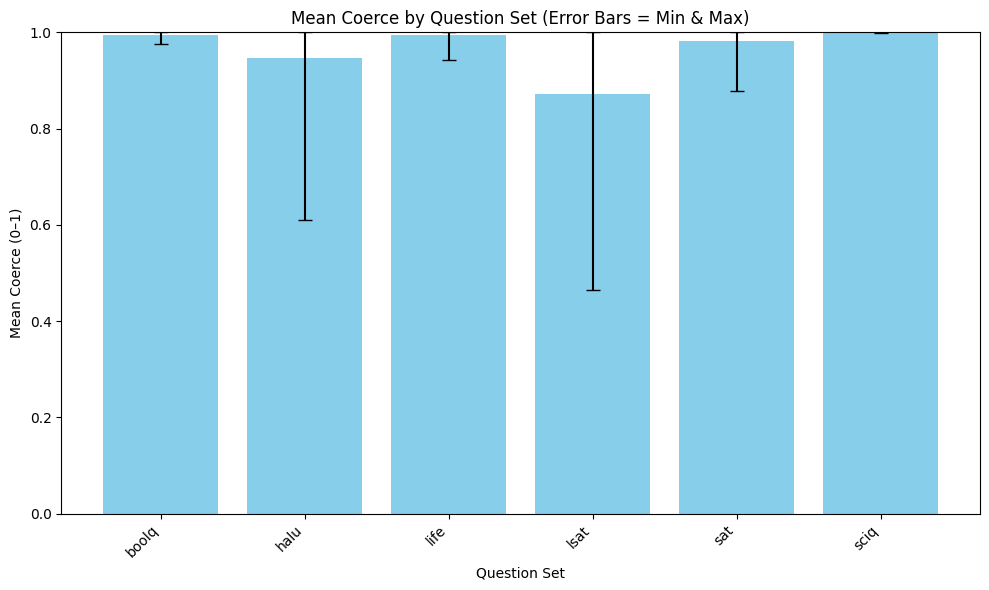

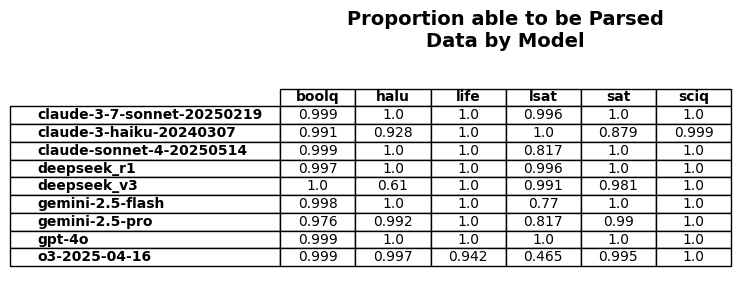

In [486]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path("Parsed Results")  # change path if needed
rows = []

for provider in base_dir.iterdir():
    if provider.is_dir():
        for model_type in provider.iterdir():
            if model_type.is_dir():
                for csv_file in model_type.glob("*.csv"):
                    fname = csv_file.stem
                    question_set = fname.split("_")[0]
                    try:

                        df = pd.read_csv(csv_file)
                        mean_val = np.mean(df.dropna(axis=1, how='all').notna().all(axis=1)) # Drops any irrelevant columns and then sees if there are any rows with incomplete sections
                        rows.append({
                            "Model Type": model_type.name,
                            "Question Set": question_set,
                            "Mean Coerce": mean_val
                        })
                    except Exception as e:
                        print(f"Error reading {csv_file}: {e}")

results_df = pd.DataFrame(rows)

# Pivot so rows = model type, columns = question set
pivot_df = results_df.pivot_table(
    index="Model Type",
    columns="Question Set",
    values="Mean Coerce",
    aggfunc="mean"
).round(3)

display(pivot_df)
# Calculate stats per question set
means = pivot_df.mean(axis=0)
mins = pivot_df.min(axis=0)
maxs = pivot_df.max(axis=0)

# Error bar values
error_lower = means - mins
error_upper = maxs - means

plt.figure(figsize=(10, 6))
plt.bar(means.index, means.values, yerr=[error_lower, error_upper], capsize=5, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Mean Coerce (0–1)")
plt.xlabel("Question Set")
plt.title("Mean Coerce by Question Set (Error Bars = Min & Max)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Create a clean table image
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
ax.set_title("Proportion able to be Parsed\nData by Model", fontweight='bold', fontsize=14, pad=20)
table = ax.table(
    cellText=pivot_df.round(3).values,
    colLabels=pivot_df.columns,
    rowLabels=pivot_df.index,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Make header bold
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# --- Fix DeepSeek naming scheme
rename_map = {
    "deepseek_r1": {
        "boolq_valid_processed.csv": "boolq_valid_deepseek-r1.csv",
        "halu_eval_qa_processed.csv": "halu_eval_qa_deepseek-r1.csv",
        "life_eval_deepseek-reasoner_reasoning_results_wide.csv": "life_eval_deepseek-r1.csv",
        "lsat_ar_test_processed.csv": "lsat_ar_test_deepseek-r1.csv",
        "sat_en_processed.csv": "sat_en_deepseek-r1.csv",
        "sciq_test_processed.csv": "sciq_test_deepseek-r1.csv",
    },
    "deepseek_v3": {
        "boolq_valid_deepseek-chat_results_wide.csv": "boolq_valid_deepseek-v3.csv",
        "halu_eval_qa_processed.csv": "halu_eval_qa_deepseek-v3.csv",
        "life_eval_processed.csv": "life_eval_deepseek-v3.csv",
        "lsat_ar_test_processed.csv": "lsat_ar_test_deepseek-v3.csv",
        "sat_en_processed.csv": "sat_en_deepseek-v3.csv",
        "sciq_test_processed.csv": "sciq_test_deepseek-v3.csv",
    }
}

base_dir = "Parsed Results\\Deepseek"

for subdir, files in rename_map.items():
    for old, new in files.items():
        old_path = os.path.join(base_dir, subdir, old)
        new_path = os.path.join(base_dir, subdir, new)
        if os.path.exists(old_path):
            os.rename(old_path, new_path)
            print(f"Renamed {old} -> {new}")

##  Question Set Analysis

In [553]:
# -- KEEP
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import seaborn as sns

# base palettes per family
family_palettes = {
    "GPT":    sns.color_palette("Greens", 6),
    "Claude": sns.color_palette("Blues", 6),
    "Gemini": sns.color_palette("Purples", 6),
    "DeepSeek":  sns.color_palette("Oranges", 6),
}

# --- Function Definitions ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "GPT"
    if "claude" in s:             return "Claude"
    if "gemini" in s:             return "Gemini"
    if "deepseek" in s:           return "DeepSeek"
    return "other"


def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "GPT":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "Claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "Gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    if fam == "DeepSeek":
        if "r1"   in s:  return pal[-2]
        if "v3" in s:  return pal[2]
    return pal[3]  # default mid shade

'''
def make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, num_used, title_prefix="BoolQ", filename="summary_bars_boolq.png"):
    # Build dataframes
    ece_df = pd.DataFrame(ece_rows, columns=["model", "ece", "family", "color"])
    oc_df = pd.DataFrame(oc_rows, columns=["model", "over_confidence", "family", "color"])
    acc_df = pd.DataFrame(acc_rows, columns=["model", "acc", "family", "color"])
    n_df   = pd.DataFrame(n_rows,   columns=["model", "n",   "family", "color"])

    # Sort (family then model) and establish a consistent model order from ECE df
    ece_df = ece_df.sort_values(["family", "model"]).reset_index(drop=True)
    model_order = ece_df["model"].tolist()

    # Reindex others to match the model order
    def reorder(df, value_col):
        if df.empty:
            return df
        df = df.set_index("model").reindex(model_order).reset_index()
        # Forward-fill missing family/color if needed (rare)
        for col in ["family", "color"]:
            if col in df:
                df[col] = df[col].ffill().bfill()
        return df

    acc_df = reorder(acc_df, "acc")
    n_df   = reorder(n_df, "n")   

    # Figure and axes
    n_models = len(model_order)
    fig_w = max(14, 0.6 * n_models + 10)  # scale width with #models
    fig, axes = plt.subplots(1, 3, figsize=(fig_w, 6), sharex=False)

    # Panel configs
    panels = [
        (ece_df, "ece", "ECE", f"{title_prefix} — Expected Calibration Error"),
        (acc_df, "acc", "Accuracy", f"{title_prefix} — Accuracy by Model"),
        (n_df,   "n",   "Count (n)", f"{title_prefix} — Usable Rows by Model"),
    ]

    # Draw bars
    for ax, (df, val_col, y_label, title) in zip(axes, panels):
        #display(df)
        #if df.empty:
        #     ax.set_axis_off()
        #     ax.set_title(f"{title}\n(no data)")
        #     continue
        #display(df[val_col])
        x = df["model"]
        y = np.array(df[val_col])


        ax.bar(x, y, color=list(df["color"]), linewidth = 0)
        ax.set_ylabel(y_label)
        ax.set_title(title)

        # Y-lims: probabilities on [0,1], counts auto
        if val_col in ("ece"):
            ax.set_ylim(0, 1)
        else:
            ymax = (df[val_col].max() or 0) * 1.10
            ax.set_ylim(0, max(1, ymax))

        if "Usable Rows" in title:
            min_val = num_used
            ax.axhline(min_val, color="grey", linestyle="--", linewidth=1.5)

            ax.text(
                1.01, min_val,                       # X=just outside plot (normalized coords), Y=actual val
                f"{min_val:.0f}",                    # format as integer (change to .2f if decimals matter)
                va="center", ha="left", color="black",
                transform=ax.get_yaxis_transform()   # ensures y is in data coords, x is relative (0–1)
            )
        

        # Rotate x labels for readability
        #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # Deprecated method
        ax.set_xticks(ax.get_xticks())  # explicitly set tick positions
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Build a single legend from families present
    families_present = pd.concat([ece_df["family"], acc_df["family"], n_df["family"]], axis=0).dropna().unique().tolist()
    #print(families_present)
    # Expect a dict named family_palettes in scope; fall back to greys if missing
    legend_patches = []
    for fam in families_present:
        try:
            face = family_palettes.get(fam, None)
            if face is None:
                raise KeyError
            face = face[3]  # a mid shade
        except Exception:
            # fallback color if palette not defined for this family
            face = "#cfcfcf"
        # Prettify family label
        fam_label = fam.capitalize()
        legend_patches.append(Patch(facecolor=face, label=fam_label))

    if legend_patches:
        # Put legend under the middle subplot
        axes[0].legend(handles=legend_patches, title="Model Families", frameon=True, loc="upper left")
    fig.suptitle(f"Summary Statistics for {title_prefix}", fontsize=16, y=1.02)
    plt.tight_layout()

    # Save once
    filename = f"summary_bars_{title_prefix.lower()}.png"
    out_path = output_dir / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return out_path

'''

def make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, num_used,
                       title_prefix="BoolQ", filename=None):
    # --- Build dataframes ---
    ece_df = pd.DataFrame(ece_rows, columns=["model", "ece", "family", "color"])
    oc_df  = pd.DataFrame(oc_rows,  columns=["model", "over_confidence", "family", "color"])
    acc_df = pd.DataFrame(acc_rows, columns=["model", "acc", "family", "color"])
    n_df   = pd.DataFrame(n_rows,   columns=["model", "n",   "family", "color"])

    # Establish model order from ECE (family then model)
    ece_df = ece_df.sort_values(["family", "model"]).reset_index(drop=True)
    model_order = ece_df["model"].tolist()

    # Reindex helpers to align models and carry family/color forward/backward
    def reorder(df):
        if df.empty:
            return df
        df = df.set_index("model").reindex(model_order).reset_index()
        for col in ("family", "color"):
            if col in df:
                df[col] = df[col].ffill().bfill()
        return df

    oc_df  = reorder(oc_df)
    acc_df = reorder(acc_df)
    n_df   = reorder(n_df)

    # --- Figure & axes (2 x 2) ---
    n_models = max(1, len(model_order))
    fig_w = max(12, 0.55 * n_models + 8)
    fig, axes = plt.subplots(2, 2, figsize=(fig_w, 10), sharex=False)
    axes = axes.flatten()

    # Order: top-left ECE, top-right OC, bottom-left ACC, bottom-right N
    panels = [
        (ece_df, "ece",             "ECE",             f"{title_prefix} — Expected Calibration Error by Model"),
        (oc_df,  "over_confidence", "Over Confidence", f"{title_prefix} — Over Confidence by Model"),
        (acc_df, "acc",             "Accuracy (%)",        f"{title_prefix} — Accuracy by Model"),
        (n_df,   "n",               "Count (n)",       f"{title_prefix} — Usable Rows by Model"),
    ]

    for ax, (df, val_col, y_label, title) in zip(axes, panels):
        
        x = df["model"] if not df.empty else []
        y = np.array(df[val_col]) if not df.empty else np.array([])

        ax.bar(x, y, color=(list(df["color"]) if not df.empty else None), linewidth=0, zorder = 2)
        ax.set_ylabel(y_label)
        ax.set_title(title)

        # Y-lims
        ymin = 0
        if val_col in ("ece"):
            ax.set_ylim(0, 1)
        else:
            ymax = (float(df[val_col].max()) if not df.empty else 0.0) * 1.10
            ymin = (float(df[val_col].min()) if not df.empty else 0.0) * 2.5 # this is a small number most of the time
            ax.set_ylim(min(0, ymin), max(1, ymax))

        # Horizontal reference line for N panel
        if val_col == "n":
            min_val = num_used
            ax.axhline(min_val, color="grey", linestyle="--", linewidth=1.5)
            ax.text(1.01, min_val, f"{min_val:.0f}", va="center", ha="left",
                    color="black", transform=plt.gca().get_yaxis_transform())

        if ymin < 0:
            ax.axhline(0, color="black", linestyle="-", linewidth=1.5)
        # Rotate x labels
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels(x, rotation=45, ha="right")
        ax.grid(zorder=0)

    # Legend from families present across all panels
    families_present = pd.concat(
        [df["family"] for df in (ece_df, oc_df, acc_df, n_df) if not df.empty],
        axis=0
    ).dropna().unique().tolist()

    legend_patches = []
    for fam in families_present:
        try:
            face = family_palettes.get(fam, None)
            if face is None:
                raise KeyError
            face = face[3]
        except Exception:
            face = "#cfcfcf"
        legend_patches.append(Patch(facecolor=face, label=fam))

    if legend_patches:
        axes[0].legend(handles=legend_patches, title="Model Families",
                       frameon=True, loc="upper left")

    fig.suptitle(f"Summary Statistics for {title_prefix}", fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save
    if filename is None:
        filename = f"summary_bars_{title_prefix.lower()}.png"
    out_path = output_dir / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return out_path

def compute_overconfidence_mcq(df: pd.DataFrame, qset: str):
    """
    Compute mean confidence, accuracy, and overconfidence for one LLM–question set.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['A','B','C','D','E','Correct Answer Letter'] 
        where A–E are probabilities (floats summing to 1 per row).
    
    Returns
    -------
    dict with mean_confidence, accuracy, overconfidence
    """

    
    # Columns with option probs
    if qset == 'LSAT-AR':
        option_cols = ['A','B','C','D','E']
    else:
        option_cols = ['A','B','C','D']
    # Confidence per question = highest assigned probability
    max_probs = df[option_cols].max(axis=1)

    # For ties, find which answers are tied for max
    is_max = df[option_cols].eq(max_probs, axis=0)
    n_ties = is_max.sum(axis=1)  # number of options tied for max
    
    ## Did the correct answer get max probability?
    correct_mask = [c for c in df['Correct Answer Letter']]
    #correct_is_max = is_max.lookup(df.index, correct_mask) --- deprecated

    # Column labels of correct answers
    correct_mask = df['Correct Answer Letter']

    # Convert to numpy arrays
    rows = np.arange(len(df))
    cols = is_max.columns.get_indexer(correct_mask)

    # Get the value at (row, correct_col) for each row
    correct_is_max = is_max.to_numpy()[rows, cols]
    
    # Per-question accuracy: 1/k if correct is among ties, else 0
    per_question_acc = np.where(correct_is_max, 1/n_ties, 0)
    
    # Aggregate
    mean_conf = max_probs.mean()
    accuracy = per_question_acc.mean()
    overconf = mean_conf - accuracy
    
    return overconf

def compute_overconfidence_bool(df: pd.DataFrame):

    accuracy = np.mean(df['Correct Answer'].str.strip().str.lower() == df['Answer'].str.strip().str.lower()) # I know this is redundant I just want to make the functions similar
    conf = np.mean(df['Confidence'])

    overconf = conf - accuracy
    
    return overconf

def calibration_plot(
        scores: pd.Series, 
        confidence: pd.Series, 
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None
        ):
    # Ensure inputs are numpy arrays
    scores = scores.astype(int).to_numpy()
    confidence = confidence.astype(float).to_numpy()
    
    # Calculate ECE and Accuracy
    ece = get_ece(pd.Series(scores), pd.Series(confidence), n_bins=n_bins)
    acc = np.mean(scores)

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Stated Confidence',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis


    # --- Save Plot ---
    filename = f"cal_plot_{qset_key.lower()}_{model_key}.png"
    out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    
    #plt.tight_layout()
    #plt.show()

    return ece, acc
    
def mcq_calibration_plot(df: pd.DataFrame,
        options: list = [],
        gold_column: str = 'Correct Answer Letter',
        answer_column: str = 'Answer',
        n_bins: int = 10,
        model_name: str = '',
        qset_name: str = '',
        num_complete: int = None,
        title: str = None,
        show = False,
        save = True
        ):
    

    # Calculate ECE and Accuracy before melting df

    summary_df =  pd.DataFrame({
        "answer": df[options].idxmax(axis=1),      # letter with max prob
        "confidence": df[options].max(axis=1)      # highest prob
    })
    summary_df['score'] = summary_df['answer'].str.lower().str.strip() == df[gold_column].str.lower().str.strip()
    

    ece = get_ece(summary_df["score"], summary_df["confidence"], n_bins=n_bins)
    acc = np.mean(summary_df["score"])


    # Now melt df to get what we need for plots
    melted = df.melt(
        id_vars=['Question ID', gold_column],
        value_vars=options,
        var_name='Option',
        value_name='confidence'
        )

    #display(full_df)
    melted = melted.sort_values(["Question ID", "Option"])


    #print(full_df.shape)

    melted['score'] = (melted[gold_column].str.strip() == melted['Option']).astype(int)
    melted

    scores = melted['score']
    confidence = melted['confidence']

    

    melted = melt_series(score=scores, confidence=confidence)
    #display(melted)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ## Line of Well Calibration
    ax.plot([0, 1.1], [0, 1.1], linestyle='--', color='grey')

    ## Histogram:
    ax.bar(
        melted['mean_confidence'].fillna(0), 
        melted['count'].fillna(0) / melted['count'].sum(), 
        width=0.025, 
        align='center', 
        edgecolor='white',
        color = 'orange'
        )
    ax.scatter(melted['mean_confidence'], melted['mean_score'])


    ## Error Bars:
    # Standard error for a proportion
    stderr = np.sqrt((melted['mean_score'] * (1 - melted['mean_score'])) / melted['count'])
    stderr = stderr.fillna(0)  # no error if count = 0 or NaN

    ax.errorbar(melted['mean_confidence'], 
                melted['mean_score'], 
                yerr = stderr,  
                fmt='o', 
                ecolor='grey', 
                capsize=5,
                #linestyle = 'none'
                )
    
    ax.scatter(melted['mean_confidence'], melted['mean_score'], color = 'blue')


    # 45-degree reference line


    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Average Accuracy', labelpad= 15)
    if title is not None:
        ax.set_title(f'{title}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}')
    else:
        ax.set_title(f'Calibration Plot for {model_name} on {qset_name}\nECE: {ece:.3f} | Accuracy: {acc:.3f} | n = {num_complete}' )
    ticks = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    labels = [0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6,0.7,0.7,0.8,0.9,1.0]
    ax.set_xticks(ticks= ticks, labels=labels)

    # Create a secondary y-axis for proportion
    ax2 = ax.twinx()
    ax.set_ylim(0, 1.1)
    ax2.set_ylabel('Proportion of Stated Confidence',rotation=-90, labelpad= 15)

    ax.set_ylim(0, 1.1)
    ax2.set_ylim(0, 1.1)
    #ax.grid(False)   # turn off grid for left axis
    #ax2.grid(False)  # turn off grid for right axis


    # --- Save Plot ---
    filename = f"cal_plot_{qset_key.lower()}_{model_key}.png"
    out_path = output_dir / "Calibration Plots"  / filename  # assumes output_dir exists
    
    if save:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    if show:
        plt.tight_layout()
        plt.show()

    return ece, acc

def get_ece(score: pd.Series, confidence: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    score = score.astype(bool)
    confidence = confidence.astype(float)

    # Bin edges and assignments
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            ece += (bin_count / total_count) * abs(bin_accuracy - bin_confidence)

    return ece

def sum_token_logprobs_boolq(old_df: pd.DataFrame):
    df = old_df.copy()
    truthy = ['True', 'true', 'TRUE', 'yes', 'Yes']
    falsey = ['False', 'false', 'FALSE', 'no', 'No']

    # Strip spaces for all t-columns
    t_cols = [f"t{i}" for i in range(1, 6)]
    p_cols = [f"t{i}_prob" for i in range(1, 6)]
    df[t_cols] = df[t_cols].apply(lambda col: col.str.strip())

    # Boolean masks for truthy/falsey per cell
    mask_truthy = df[t_cols].isin(truthy)
    mask_falsey = df[t_cols].isin(falsey)

    # Multiply masks by probability columns (automatically aligns column-wise)
    df["true_sum"] = (mask_truthy * df[p_cols].to_numpy()).sum(axis=1)
    df["false_sum"] = (mask_falsey * df[p_cols].to_numpy()).sum(axis=1)

    t_prob = df['true_sum'] / (df['false_sum'] + df['true_sum'])
    f_prob = df['false_sum'] / (df['false_sum'] + df['true_sum'])

    df['true_token_prob'] = t_prob
    df['false_token_prob'] = f_prob

    return df

def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels
    bins = np.linspace(0, 1, 11)        # 0.0, 0.1, ..., 1.0
    bins = np.append(bins, 1.0000001)    # ensure 1.0 is captured in last bin
    labels = [round(x, 1) for x in np.linspace(0.1, 1.0, 11)]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        ordered= False,
        right=False,   # (a, b] style
        include_lowest=False
    )

    return df

def melt_series(score: pd.Series, confidence: pd.Series):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('int')
    #print('Binned DF:')
    #display(df)
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        #observed=True,
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df




## Main Plots

In [554]:
## Make All Plots
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

model_names = {
    "GPT": {
        "gpt-4o": "GPT-4o",
        "o3-2025-04-16": "GPT-o3",
    },
    "Claude":{
        "claude-sonnet-4-20250514": "Claude-Sonnet-4",
        "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
        "claude-3-haiku-20240307": "Claude Haiku 3",
    },
    "Gemini":{
        "gemini-2.5-pro": "Gemini-2.5-Pro",
        "gemini-2.5-flash": "Gemini-2.5-Flash"
    },
    "Deepseek": {
        "deepseek-r1": "DeepSeek-R1",
        "deepseek-v3": "DeepSeek-V3"
    }
}

qsets = {
    "boolq_valid": "BoolQ",
    "halu_eval_qa": "HaluEval",
    "life_eval": "LifeEval",
    "lsat_ar_test": "LSAT-AR",
    "sat_en": "SAT-EN",
    "sciq_test": "SciQ"
}

response_map = {
    'true': True,
    'false': False,
    'a': 'A',
    'b': 'B',
    'c': 'C',
    'd': 'D',
    'e': 'E'
}

mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


folder = "Parsed Results"
folder_gold = "Formatted Benchmarks"
dfs = {}  # store DataFrames in a dict keyed by (qset_name, model_display)
completions = {}

for qset_key, qset_name in qsets.items():

    print(f"{qset_name}:")
    output_dir = Path("Plots") / qset_name
    output_dir.mkdir(parents=True, exist_ok=True)
    dfs[qset_name] = {}
    completions[qset_name] = {}
    # Get gold_df for this qset
    gold_filename =  f"{qset_key}_formatted.csv"
    gold_path = os.path.join(folder_gold, gold_filename)
    print(f"    ✅{gold_filename}")
    if os.path.exists(gold_path):
        gold_df = pd.read_csv(gold_path)
    else:
        print(f"Missing gold file: {gold_path}")
        gold_df = None
        continue
    
    for model_group, models in model_names.items():
        print(f"    {model_group}:")

        # --- Iterate over each model in group ---
        for model_key, model_display in models.items():
            filename = f"{qset_key}_{model_key}.csv"
            filepath = os.path.join(folder, model_group, model_key, filename)
            completions[model_display] = {}
            # --- Get the Parsed Result CSV ---
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                dfs[qset_name][model_display] = df
                print(f"        ✅{filename}")
            else:
                print(f"Missing: {filepath}")

            n = df.dropna(axis=1, how='all').notna().all(axis=1).sum()                         #------HERE

            completions[qset_name][model_display] = n

    print(f"✅All Dataframes Imported for {qset_name}!\nRunning Analysis:")

    # --- Find Usable IDs ---
    # if qset_name != 'LifeEval' and qset_name != 'HaluEval':                 # Add logic for these two
    #     continue
    if qset_name != 'HaluEval' and qset_name != 'LifeEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        df['Answer'].astype(str).str.strip().str.lower()
                                .map(response_map).notna(), 
                        'Question ID'
                        ]
                    )
                for df in models_dict.values()
            ])
            #for qset_name, models_dict in dfs.items()
        }
        
    elif qset_name == 'HaluEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        df['Confidence'].notna(),  # HaluEval only looks for confidence values
                        'Question ID'
                        ]
                    )
                for df in models_dict.values()
            ])
            #for qset_name, models_dict in dfs.items()
        }
    elif qset_name == 'LifeEval':
        models_dict = dfs[qset_name]
        valid_ids = {
            qset_name: set.intersection(*[
                set(
                    df.loc[
                        (pd.to_numeric( df['Answer'], errors='coerce').notna()) &
                        (pd.to_numeric( df['Confidence'], errors='coerce').notna()),
                        'Question ID'
                    ]
                )
                for df in models_dict.values()
            ])
        }

    # --- Convert DFs to only usable IDs ---
    ids = {str(x) for x in valid_ids[qset_name]}
    gold_df = gold_df[gold_df['Question ID'].astype(str).isin(ids)].reset_index(drop=True)
    print(f"Usable Rows: {len(ids)}")                                         # This doesn't match with the n outputted? Must debug
    old_dfs = dfs.copy()
    for model_display, df in dfs[qset_name].items():

        mask = df['Question ID'].astype(str).isin(ids)



        #print(gold_df.columns)
        
        dfs[qset_name][model_display] = df.loc[mask].copy()

    # --- Run Summary Analysis ---                                            # This method may not be best implementation.

    ece_rows = []
    acc_rows = []
    n_rows = []
    oc_rows = []
    n_used = len(ids)
    for model_group, models in model_names.items():
        for model_key, model_display in models.items():

            # --- Get Response Confidence and Scores Series ---                 ## Need to do
            if qset_name == 'BoolQ': 
                df = dfs[qset_name][model_display]
                response_orig = df['Answer']
                response = (response_orig.astype(str).str.strip().str.lower()
                            .map(response_map)
                            ).reset_index(drop = True)
                confidence = df['Confidence']
                scores = gold_df['Correct Answer'] == response.astype('bool')
            elif qset_name == 'HaluEval':
                df =  dfs[qset_name][model_display]                             # Need to do
                confidence = df['Confidence'] 
                scores = df['Question ID'].str.contains('_r') # Marker for real/ hallucinated answer

            elif qset_name == 'LifeEval':
                df = dfs[qset_name][model_display]

                # Get Radius
                radius_list = [1, 5, 10, 20]
                # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
                mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


                rads = mod_qid.apply(lambda i: radius_list[i])
                df['radius'] = rads

                # Get True age
                true_val = gold_df['True Lifespan']

                # Get Answer:

                response = df['Answer']

                df['Expected Age'] = true_val


                scores = (
                    (df['Answer'].astype(float) >= df['Expected Age'] - df['radius']) &
                    (df['Answer'].astype(float) <= df['Expected Age'] + df['radius'])
                ).astype(int)

                confidence = df['Confidence']
                

            elif qset_name == 'LSAT-AR':
                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D', 'E']
                gold_column_name = "Correct Answer Letter"

            elif qset_name == 'SAT-EN':

                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D']
                gold_column_name = "Correct Answer Letter"
            elif qset_name == 'SciQ':
                full_df = dfs[qset_name][model_display]


                full_df = full_df.merge(
                    gold_df[['Question ID', 'Correct Answer Letter']],
                    on='Question ID',
                    how='inner',
                    validate='one_to_one'
                )

                answer_options = ['A', 'B', 'C', 'D']
                gold_column_name = "Correct Answer Letter"
            else:
                print(f'Invalid Q-Set! {qset_name} not found!')

            # --- Multiple Choice Question Calibration Plots ---
            if qset_name in mcq_qsets:          
                ece, acc = mcq_calibration_plot(full_df, 
                                                options= answer_options, 
                                                gold_column= gold_column_name, 
                                                model_name = model_display, 
                                                qset_name = qset_name, 
                                                num_complete = n_used
                                                )
                acc = acc * 100

                #n = old_dfs[qset_name][model_display]['answer'].notna().sum()
                n = completions[qset_name][model_display]

                over_confidence = compute_overconfidence_mcq(full_df, qset_name)

             # --- Make Calibration Plot --- # Need to do
            else:
                n = completions[qset_name][model_display]
                acc = np.mean(scores) *100
                ece = get_ece(scores, confidence)
                over_confidence = np.mean(confidence.astype(float)) - np.mean(scores.astype(int)) 
                calibration_plot(scores= scores, confidence = confidence, model_name = model_display, qset_name = qset_name, num_complete = n_used)

            # --- Summary Stats ---
            print(f"Raw Summary Stats: {model_display}")
            print(f"                Accuracy: {acc:.2f}%")
            print(f"         Over Confidence: {over_confidence}")
            print(f"                     ECE: {ece:.3f}")
            print(f"                       n: {n}")

            # --- Add Summary Stats ---
            fam = model_family(model_display)
            color = pick_color(model_display)
            ece_rows.append((model_display, float(ece), fam, color))
            acc_rows.append((model_display, acc, fam, color))
            n_rows.append((model_display, float(n), fam, color))
            oc_rows.append((model_display, over_confidence, fam, color))

            
    # --- Analysis Plots ---
    output_dir = Path("Plots") / qset_name 
    output_dir.mkdir(parents=True, exist_ok=True)
    make_summary_plots(ece_rows, oc_rows, acc_rows, n_rows, n_used, title_prefix = qset_name)


BoolQ:
    ✅boolq_valid_formatted.csv
    GPT:
        ✅boolq_valid_gpt-4o.csv
        ✅boolq_valid_o3-2025-04-16.csv
    Claude:
        ✅boolq_valid_claude-sonnet-4-20250514.csv
        ✅boolq_valid_claude-3-7-sonnet-20250219.csv
        ✅boolq_valid_claude-3-haiku-20240307.csv
    Gemini:
        ✅boolq_valid_gemini-2.5-pro.csv
        ✅boolq_valid_gemini-2.5-flash.csv
    Deepseek:
        ✅boolq_valid_deepseek-r1.csv
        ✅boolq_valid_deepseek-v3.csv
✅All Dataframes Imported for BoolQ!
Running Analysis:
Usable Rows: 2542
Raw Summary Stats: GPT-4o
                Accuracy: 85.29%
         Over Confidence: 0.07965381589299758
                     ECE: 0.080
                       n: 3268
Raw Summary Stats: GPT-o3
                Accuracy: 86.07%
         Over Confidence: -0.034909520062942456
                     ECE: 0.045
                       n: 3268
Raw Summary Stats: Claude-Sonnet-4
                Accuracy: 84.42%
         Over Confidence: 0.07426829268292678
             

In [519]:
full_df

,Unnamed: 0,Reasoning,Answer,A,B,C,D,E,coerce,content,Question ID,Correct Answer Letter
0,0,Option C is the only schedule that satisfies a...,C,0.0,0.0,1.00,0.0,0.00,True,"{\n""Reasoning"": ""Option C is the only schedule...",0,C
1,2,George can only give a report on Tuesday. If N...,B,0.1,0.7,0.05,0.1,0.05,True,"{\n""Reasoning"": ""George can only give a report...",2,B
2,3,George can only give a report on Tuesday. Nina...,B,0.1,0.6,0.10,0.1,0.10,True,"{\n""Reasoning"": ""George can only give a report...",3,A
3,5,"If Helen, Kyle, and Lenore give the morning re...",A,0.6,0.1,0.10,0.1,0.10,True,"{\n""Reasoning"": ""If Helen, Kyle, and Lenore gi...",5,B
4,6,"Option A selects 2 Russian novels, violating t...",D,0.0,0.0,0.00,1.0,0.00,True,"{\n""Reasoning"": ""Option A selects 2 Russian no...",6,C
...,...,...,...,...,...,...,...,...,...,...,...,...
56,211,"Given the conditions, if Mei is on the green t...",B,0.0,1.0,0.00,0.0,0.00,True,"{\n""Reasoning"": ""Given the conditions, if Mei ...",211,E
57,212,Option A violates the constraint that U and X ...,D,0.0,0.0,0.00,1.0,0.00,True,"{\n""Reasoning"": ""Option A violates the constra...",212,C
58,213,"If X is in chapter 1, U must be in chapter 2 d...",A,0.6,0.1,0.10,0.1,0.10,True,"{\n""Reasoning"": ""If X is in chapter 1, U must ...",213,E
59,214,"If U is in chapter 3, X must be in chapter 4 d...",C,0.0,0.0,1.00,0.0,0.00,True,"{\n""Reasoning"": ""If U is in chapter 3, X must ...",214,A


In [494]:
ece_rows

[('GPT-4o',
  0.053453453453453315,
  'gpt',
  (0.17139561707035755, 0.581514801999231, 0.2979008073817762)),
 ('GPT-o3',
  0.1538938938938939,
  'gpt',
  (0.7371472510572856, 0.895517108804306, 0.7108342945021145)),
 ('Claude-Sonnet-4',
  0.05385385385385383,
  'claude',
  (0.16696655132641292, 0.48069204152249134, 0.7291503267973857)),
 ('Claude-Sonnet-3.7',
  0.04891891891891893,
  'claude',
  (0.16696655132641292, 0.48069204152249134, 0.7291503267973857)),
 ('Claude Haiku 3',
  0.10895895895895885,
  'claude',
  (0.5356862745098039, 0.746082276047674, 0.8642522106881968)),
 ('Gemini-2.5-Pro',
  0.032014014014013915,
  'gemini',
  (0.440722798923491, 0.36772010765090346, 0.6653902345251825)),
 ('Gemini-2.5-Flash',
  0.03800800800800806,
  'gemini',
  (0.6878892733564014, 0.6835832372164552, 0.829834678969627)),
 ('DeepSeek-R1',
  0.04319719719719717,
  'deepseek',
  (0.8782929642445213, 0.31990772779700116, 0.024405997693194924)),
 ('DeepSeek-V3',
  0.10420420420420422,
  'deepseek'

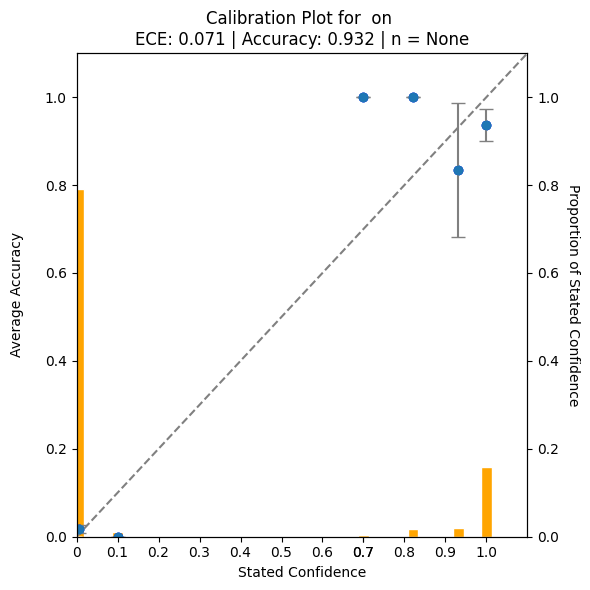

(0.07101694915254234, 0.9322033898305084)

In [207]:
lsat_df
gold_df = pd.read_csv("Formatted Benchmarks\\lsat_ar_test_formatted.csv")
qset_name = "LSAT-AR"


models_dict = dfs[qset_name]
valid_ids = {
    qset_name: set.intersection(*[
        set(
            df.loc[
                df['Answer'].astype(str).str.strip().str.lower()
                        .map(response_map).notna(), 
                'Question ID'
                ]
            )
        for df in models_dict.values()
    ])
    #for qset_name, models_dict in dfs.items()
}
ids = {str(x) for x in valid_ids[qset_name]}
gold_df = gold_df[gold_df['Question ID'].astype(str).isin(ids)].reset_index(drop=True)

# --- Only need this part ---

full_df = lsat_df.copy()

full_df = full_df.merge(
    gold_df[['Question ID', 'Correct Answer Letter']],
    on='Question ID',
    how='inner',
    validate='one_to_one'
)
full_df

melted = full_df.melt(
      id_vars=['Question ID', 'Correct Answer Letter'],
      value_vars=['A', 'B', 'C', 'D', 'E'],
      var_name='Option',
      value_name='confidence'
    )

#display(full_df)
melted = melted.sort_values(["Question ID", "Option"])


#print(full_df.shape)

melted['score'] = (melted['Correct Answer Letter'].str.strip() == melted['Option']).astype(int)
melted

scores = melted['score']
confidence = melted['confidence']

np.mean(scores)

full_df

letter_options = ['A', 'B', 'C', 'D', 'E']

mcq_calibration_plot(full_df, options= letter_options, save= False, show= True)


In [ ]:


# --- Where to save ---
output_dir = Path("Plots") / "BoolQ" / "Calibration Plots"
output_dir.mkdir(parents=True, exist_ok=True)

# --- Color helpers: families & shades ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "gpt"
    if "claude" in s:             return "claude"
    if "gemini" in s:             return "gemini"
    return "other"

# base palettes per family
family_palettes = {
    "gpt":    sns.color_palette("Greens", 6),
    "claude": sns.color_palette("Blues", 6),
    "gemini": sns.color_palette("Purples", 6),
    "other":  sns.color_palette("Greys", 6),
}

def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "gpt":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    return pal[3]  # default mid shade

# --- Collect ECEs here ---
ece_rows = []   # (model_name, ece, family, color)

for provider in base_dir.iterdir():
    if not provider.is_dir():
        continue
    for model_type in provider.iterdir():
        if not model_type.is_dir():
            continue

        files = [p for p in model_type.glob("*.csv") if "boolq" in p.stem]
        n = len(files)
        if n == 0:
            continue

        # One figure per model_type, multiple subplots side-by-side
        fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
        for i, csv_file in enumerate(files):
            ax = axes[i] if n > 1 else axes

            df = pd.read_csv(csv_file)
            # Adjust this parse if your filename pattern differs
            model_name = csv_file.stem.split("boolq_valid_")[0].rstrip("_- ")
            print(csv_file.stem)

            ece = run_analysis_boolq(df, gold_df, model_name, ax=ax)
            fam = model_family(model_name)
            color = pick_color(model_name)
            ece_rows.append((model_name, float(ece), fam, color))

            # Save the subplot figure (full figure with all subplots is saved each loop; fine if you want one per model too)
            fig_path = output_dir / f"cal_plot_boolq_{model_name}.png"
            fig.savefig(fig_path, dpi=300, bbox_inches="tight")

        plt.tight_layout()
        plt.close(fig)

# --- Build and save the ECE bar chart across all models ---
if ece_rows:
    ece_df = pd.DataFrame(ece_rows, columns=["model", "ece", "family", "color"])
    # Sort for nicer grouping (family then model)
    ece_df = ece_df.sort_values(["family", "model"]).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(max(8, 0.6 * len(ece_df) + 4), 6))
    ax.bar(ece_df["model"], ece_df["ece"], color=list(ece_df["color"]))
    ax.set_ylabel("ECE")
    ax.set_title("BoolQ — Expected Calibration Error by Model")
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", rotation=45, ha="right")

    # Legend showing family hues
    legend_patches = [
        Patch(facecolor=family_palettes["gpt"][3],    label="GPT (greens)"),
        Patch(facecolor=family_palettes["claude"][3], label="Claude (blues)"),
        Patch(facecolor=family_palettes["gemini"][3], label="Gemini (purples)"),
        Patch(facecolor=family_palettes["other"][3],  label="Other (greys)"),
    ]
    ax.legend(handles=legend_patches, title="Model Families", frameon=True)

    bar_path = output_dir / "ece_bar_boolq.png"
    fig.savefig(bar_path, dpi=300, bbox_inches="tight")
    plt.close(fig)


def make_summary_plots(ece_rows, output_dir = ''):
    ece_df = pd.DataFrame(ece_rows, columns=["model", "ece", "family", "color"])
    # Sort for nicer grouping (family then model)
    ece_df = ece_df.sort_values(["family", "model"]).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(max(8, 0.6 * len(ece_df) + 4), 6))
    ax.bar(ece_df["model"], ece_df["ece"], color=list(ece_df["color"]))
    ax.set_ylabel("ECE")
    ax.set_title("BoolQ — Expected Calibration Error by Model")
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", rotation=45, ha="right")

    # Legend showing family hues
    legend_patches = [
        Patch(facecolor=family_palettes["gpt"][3],    label="GPT (greens)"),
        Patch(facecolor=family_palettes["claude"][3], label="Claude (blues)"),
        Patch(facecolor=family_palettes["gemini"][3], label="Gemini (purples)"),
        Patch(facecolor=family_palettes["other"][3],  label="Other (greys)"),
    ]
    ax.legend(handles=legend_patches, title="Model Families", frameon=True)

    bar_path = output_dir / "ece_bar_boolq.png"
    fig.savefig(bar_path, dpi=300, bbox_inches="tight")
    plt.close(fig)